# 修改当前路径为你的数据目录

In [1]:
root_src = 'D:\DogsVsCats_finetune'#修改到你的数据文件夹目录
import os
import shutil
import time
from tqdm import tqdm
import cv2
import numpy as np
#转换目录
os.chdir(root_src)

# 定义生成文件夹函数

In [2]:
def create_directory(dir_name):
    if os.path.exists(dir_name):
        pass
    else:
        os.mkdir(dir_name)

# 根据train文件夹中的图像数据，以2:8比例分别放入validation、train2文件夹，便于用图片生成器生成数据

In [3]:
import random as rd
train_valid_split_rate = 0.2
#创建训练数据所需的文件夹
create_directory('train2')
create_directory('train2/cat')
create_directory('train2/dog')
create_directory('validation')
create_directory('validation/cat')
create_directory('validation/dog')
#获取当前狗和猫图片的文件名
filenames = os.listdir('train')
cat_filenames = list(filter(lambda x:x[:3] == 'cat', filenames))
cat_file_num = len(cat_filenames)
rd.shuffle(cat_filenames)
dog_filenames = list(filter(lambda x:x[:3] == 'dog', filenames))
dog_file_num = len(dog_filenames)
rd.shuffle(dog_filenames)

In [4]:
start = time.time()
#将cat类和dog类图片归类到train2、validation文件夹
for name in tqdm(cat_filenames[0:int(train_valid_split_rate*cat_file_num)]):
    shutil.move('./train/'+name, './validation/cat/'+name)
for name in tqdm(dog_filenames[0:int(train_valid_split_rate*dog_file_num)]):
    shutil.move('./train/'+name, './validation/dog/'+name)

for name in tqdm(cat_filenames[int(train_valid_split_rate*cat_file_num):cat_file_num]):
    shutil.move('./train/'+name, './train2/cat/'+name)
for name in tqdm(dog_filenames[int(train_valid_split_rate*cat_file_num):dog_file_num]):
    shutil.move('./train/'+name, './train2/dog/'+name)

end = time.time()
print('path deal time is %.5f s'%round(end-start,5)) 

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


path deal time is 0.01651 s


# 处理test文件夹，便于用图片生成器生成数据

In [5]:
start = time.time()
filenames = os.listdir('test')
create_directory('test/test2')
if len(filenames) <= 1:
    pass
else:
    for name in tqdm(filenames):
        shutil.move('test/'+name,'test/test2'+'/'+name)
    else:
        pass
end = time.time()
print('path deal time is %.5f s'%round(end-start,5))

path deal time is 0.28306 s


In [6]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import *
import numpy as np
BatchSize = 64
train_file_num = 25000

Using TensorFlow backend.


# 设置早停函数

In [7]:
from keras.callbacks import EarlyStopping
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=1, verbose=0, mode='auto')

# 载入InceptionV3、ResNet50、Xception的imagenet模型参数

In [8]:
base_model1 = InceptionV3(weights='imagenet', include_top=False)
base_model2 = ResNet50(weights='imagenet', include_top=False)
base_model3 = Xception(weights='imagenet', include_top=False)

In [9]:
print(len(base_model1.layers))
print(len(base_model2.layers))
print(len(base_model3.layers))

311
174
132


# 图像生成器

In [12]:
Img_enerator = ImageDataGenerator(rescale=1./255)
train_generator = Img_enerator.flow_from_directory(
        'train2',
        target_size=(299, 299),
        batch_size=BatchSize,
        class_mode='binary')
validation_generator = Img_enerator.flow_from_directory(
        'validation',
        target_size=(299, 299),
        batch_size=BatchSize,
        class_mode='binary')
test_generator = Img_enerator.flow_from_directory(
        'test',
        target_size=(299, 299),
        batch_size=BatchSize,
        class_mode='binary',
        shuffle = False)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


# 选择InceptionV3搭建基准模型

### 基准模型可视化

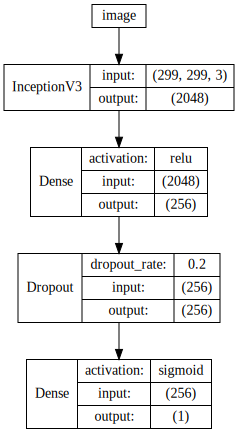

In [10]:
from graphviz import Digraph
g = Digraph('g',node_attr={'shape': 'record', 'height': '.1'})

g.node('node0','image')
g.node('node1','InceptionV3|{input:|output:}|{(299, 299, 3)|(2048)}')
g.node('node2','Dense|{activation:|input:|output:}|{relu|(2048)|(256)}')
g.node('node3','Dropout|{dropout_rate:|input:|output:}|{0.2|(256)|(256)}')
g.node('node4','Dense|{activation:|input:|output:}|{sigmoid|(256)|(1)}')

g.edge('node0','node1')
g.edge('node1','node2')
g.edge('node2','node3')
g.edge('node3','node4')
g

### 基准模型训练

In [12]:
import pandas as pd
from keras.layers.core import ActivityRegularization
# add a global spatial average pooling layer
x = base_model1.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)

# this is the model we will train
model = Model(inputs=base_model1.input, outputs=predictions)
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model1.layers:
    layer.trainable = False
    
#model.compile(optimizer=SGD(lr= 0.005, momentum=0.9),
#                  loss='binary_crossentropy',
#                  metrics=['accuracy']) 
model.compile(optimizer='adadelta',
                  loss='binary_crossentropy',
                  metrics=['accuracy']) 
# train the model on the new data for a few epochs
hist = model.fit_generator(
        train_generator,
        steps_per_epoch=int(train_file_num*(1-train_valid_split_rate)/BatchSize),
        epochs=10,
        verbose=1, 
        callbacks=[earlystopping],
        validation_data=validation_generator,
        validation_steps=int(train_file_num*train_valid_split_rate/BatchSize))
model.save_weights('InceptionV3_base.h5')
with open('InceptionV3_base.json', 'w') as f:
    f.write(model.to_json())
with open('InceptionV3_base.txt','w') as f:
    f.write(str(hist.history))

Epoch 1/10
312/312 [==============================] - 372s - loss: 0.1352 - acc: 0.9483 - val_loss: 0.0526 - val_acc: 0.9804
Epoch 2/10
312/312 [==============================] - 270s - loss: 0.0696 - acc: 0.9748 - val_loss: 0.0505 - val_acc: 0.9826
Epoch 3/10
312/312 [==============================] - 269s - loss: 0.0646 - acc: 0.9761 - val_loss: 0.0426 - val_acc: 0.9840
Epoch 4/10
312/312 [==============================] - 269s - loss: 0.0564 - acc: 0.9786 - val_loss: 0.0489 - val_acc: 0.9830
Epoch 5/10
312/312 [==============================] - 269s - loss: 0.0554 - acc: 0.9804 - val_loss: 0.0544 - val_acc: 0.9759


### 基准模型预测并提交至kaggle，获得了0.06956的评分

In [13]:
from keras.models import model_from_json

test_generator = Img_enerator.flow_from_directory(
        'test',
        target_size=(299, 299),
        batch_size=BatchSize,
        class_mode='binary',
        shuffle = False)
with open('InceptionV3_base.json', 'r') as f:
    jason_str = f.read()
model = model_from_json(jason_str)
model.load_weights('InceptionV3_base.h5')
test = model.predict_generator(test_generator,len(test_generator.filenames)/BatchSize )
y_pred = test.clip(min=0.005, max=0.995)
import pandas as pd
from keras.preprocessing.image import *
df = pd.read_csv("sample_submission.csv")
# 获取文件的序号并减1，然后设置到新预测的csv文件的序号
for i, fname in enumerate(test_generator.filenames):
    index = int((fname.split('\\')[1]).split('.')[0])
    df.set_value(index-1, 'label', y_pred[i])
df.to_csv('InceptionV3_base_sub.csv', index=None)
df.head(10)

Found 12500 images belonging to 1 classes.


,id,label
0,1,0.995
1,2,0.995
2,3,0.995
3,4,0.995
4,5,0.005
5,6,0.005
6,7,0.005
7,8,0.005
8,9,0.005
9,10,0.005


# 模型调优

## 尝试不同模型并训练部分卷积层

### 尝试Inception模型

In [27]:
import pandas as pd

# add a global spatial average pooling layer
x = base_model1.output
x = GlobalAveragePooling2D()(x)

x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)
# this is the model we will train
model = Model(inputs=base_model1.input, outputs=predictions)
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model1.layers[:250]:
    layer.trainable = False
for layer in base_model1.layers[250:]:
    layer.trainable = True
    
Img_enerator = ImageDataGenerator(rescale=1./255)
train_generator = Img_enerator.flow_from_directory(
        'train2',
        target_size=(299, 299),
        batch_size=BatchSize,
        class_mode='binary')
validation_generator = Img_enerator.flow_from_directory(
        'validation',
        target_size=(299, 299),
        batch_size=BatchSize,
        class_mode='binary')
# compile the model (should be done *after* setting layers to non-trainable)
#model.compile(optimizer=RMSprop(lr= 0.0045), loss='binary_crossentropy',metrics=['accuracy'])
model.compile(optimizer=SGD(lr=0.0001,momentum=0.9),
                  loss='binary_crossentropy',
                  metrics=['accuracy']) 
Img_enerator = ImageDataGenerator()
# train the model on the new data for a few epochs
hist = model.fit_generator(
        train_generator,
        steps_per_epoch=int(train_file_num*(1-train_valid_split_rate)/BatchSize),
        epochs=10,
        verbose=1, 
        callbacks=[earlystopping],
        validation_data=validation_generator,
        validation_steps=int(train_file_num*train_valid_split_rate/BatchSize))
model.save_weights('InceptionV3_finetune.h5')
with open('InceptionV3_finetune.json', 'w') as f:
    f.write(model.to_json())
with open('log_InceptionV3_finetune.txt','w') as f:
    f.write(str(hist.history))

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Epoch 1/10
312/312 [==============================] - 314s - loss: 0.1796 - acc: 0.9583 - val_loss: 0.0656 - val_acc: 0.9894
Epoch 2/10
312/312 [==============================] - 305s - loss: 0.0416 - acc: 0.9983 - val_loss: 0.0440 - val_acc: 0.9887
Epoch 3/10
312/312 [==============================] - 305s - loss: 0.0270 - acc: 0.9987 - val_loss: 0.0351 - val_acc: 0.9895
Epoch 4/10
312/312 [==============================] - 306s - loss: 0.0205 - acc: 0.9987 - val_loss: 0.0309 - val_acc: 0.9897
Epoch 5/10
312/312 [==============================] - 307s - loss: 0.0156 - acc: 0.9990 - val_loss: 0.0283 - val_acc: 0.9901
Epoch 6/10
312/312 [==============================] - 304s - loss: 0.0146 - acc: 0.9985 - val_loss: 0.0289 - val_acc: 0.9899
Epoch 7/10
312/312 [==============================] - 306s - loss: 0.0123 - acc: 0.9988 - val_loss: 0.0275 - val_acc: 0.9895
Epoch 8/10
312/312 [====================

### 尝试ResNet50模型

In [21]:
# add a global spatial average pooling layer
x = base_model2.output
x = GlobalAveragePooling2D()(x)

x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)
# this is the model we will train
model = Model(inputs=base_model2.input, outputs=predictions)
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model2.layers[:124]:
    layer.trainable = False
for layer in base_model2.layers[124:]:
    layer.trainable = True
# compile the model (should be done *after* setting layers to non-trainable)
#model.compile(optimizer=RMSprop(lr= 0.0045), loss='binary_crossentropy',metrics=['accuracy'])
model.compile(optimizer=SGD(lr=0.0002,momentum=0.9),
                  loss='binary_crossentropy',
                  metrics=['accuracy']) 
Img_enerator = ImageDataGenerator()
train_generator = Img_enerator.flow_from_directory(
        'train2',
        target_size=(224, 224),
        batch_size=BatchSize,
        class_mode='binary')
validation_generator = Img_enerator.flow_from_directory(
        'validation',
        target_size=(224, 224),
        batch_size=BatchSize,
        class_mode='binary')
# train the model on the new data for a few epochs
hist = model.fit_generator(
        train_generator,
        steps_per_epoch=int(train_file_num*(1-train_valid_split_rate)/BatchSize),
        epochs=10,
        verbose=1, 
        callbacks=[earlystopping],
        validation_data=validation_generator,
        validation_steps=int(train_file_num*train_valid_split_rate/BatchSize))
model.save_weights('ResNet50_finetune.h5')
with open('ResNet50_finetun.json', 'w') as f:
    f.write(model.to_json())
with open('log_ResNet50_finetune.txt','w') as f:
    f.write(str(hist.history))

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Epoch 1/10
312/312 [==============================] - 263s - loss: 0.2520 - acc: 0.8979 - val_loss: 0.0875 - val_acc: 0.9718
Epoch 2/10
312/312 [==============================] - 254s - loss: 0.0934 - acc: 0.9674 - val_loss: 0.0636 - val_acc: 0.9789
Epoch 3/10
312/312 [==============================] - 254s - loss: 0.0683 - acc: 0.9762 - val_loss: 0.0553 - val_acc: 0.9793
Epoch 4/10
312/312 [==============================] - 255s - loss: 0.0577 - acc: 0.9790 - val_loss: 0.0457 - val_acc: 0.9836
Epoch 5/10
312/312 [==============================] - 256s - loss: 0.0504 - acc: 0.9822 - val_loss: 0.0450 - val_acc: 0.9816
Epoch 6/10
312/312 [==============================] - 257s - loss: 0.0432 - acc: 0.9838 - val_loss: 0.0408 - val_acc: 0.9848
Epoch 7/10
312/312 [==============================] - 255s - loss: 0.0416 - acc: 0.9847 - val_loss: 0.0439 - val_acc: 0.9822
Epoch 8/10
312/312 [====================

### 尝试Xception模型

In [38]:
# add a global spatial average pooling layer
x = base_model3.output
x = GlobalAveragePooling2D()(x)

x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model3.input, outputs=predictions)
for layer in base_model3.layers[:82]:
    layer.trainable = False
for layer in base_model3.layers[82:]:
    layer.trainable = True
# compile the model (should be done *after* setting layers to non-trainable)
#model.compile(optimizer=RMSprop(lr= 0.0045), loss='binary_crossentropy',metrics=['accuracy'])
model.compile(optimizer=SGD(lr=0.0003,momentum=0.9),
                  loss='binary_crossentropy',
                  metrics=['accuracy']) 
Img_enerator = ImageDataGenerator(rescale=1./255)
train_generator = Img_enerator.flow_from_directory(
        'train2',
        target_size=(299, 299),
        batch_size=BatchSize,
        class_mode='binary')
validation_generator = Img_enerator.flow_from_directory(
        'validation',
        target_size=(299, 299),
        batch_size=BatchSize,
        class_mode='binary')

# train the model on the new data for a few epochs
hist = model.fit_generator(
        train_generator,
        steps_per_epoch=int(train_file_num*(1-train_valid_split_rate)/BatchSize),
        epochs=10,
        verbose=1, 
        callbacks=[earlystopping],
        validation_data=validation_generator,
        validation_steps=int(train_file_num*train_valid_split_rate/BatchSize))
model.save_weights('Xception_finetune.h5')
with open('Xception_finetune.json', 'w') as f:
    f.write(model.to_json())
with open('log_Xception0_finetune.txt','w') as f:
    f.write(str(hist.history))

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Epoch 1/10
312/312 [==============================] - 494s - loss: 0.1960 - acc: 0.9696 - val_loss: 0.0656 - val_acc: 0.9896
Epoch 2/10
312/312 [==============================] - 483s - loss: 0.0582 - acc: 0.9879 - val_loss: 0.0381 - val_acc: 0.9917
Epoch 3/10
312/312 [==============================] - 483s - loss: 0.0418 - acc: 0.9891 - val_loss: 0.0325 - val_acc: 0.9911
Epoch 4/10
312/312 [==============================] - 483s - loss: 0.0357 - acc: 0.9890 - val_loss: 0.0291 - val_acc: 0.9917
Epoch 5/10
312/312 [==============================] - 486s - loss: 0.0319 - acc: 0.9893 - val_loss: 0.0244 - val_acc: 0.9931
Epoch 6/10
312/312 [==============================] - 482s - loss: 0.0300 - acc: 0.9901 - val_loss: 0.0219 - val_acc: 0.9931
Epoch 7/10
312/312 [==============================] - 485s - loss: 0.0279 - acc: 0.9908 - val_loss: 0.0195 - val_acc: 0.9935
Epoch 8/10
312/312 [====================

# (2)从上述三个模型的val_loss来看，Xception的loss结果较优，所以选取Xception进行dropout参数调优
## 从下述运行结果可以看出在0.4的时候模型val_loss较低，也比较稳定

In [13]:
import pandas as pd
drop_rate_matrix = np.linspace(0.6, 0.1, 6)
for i,drop_rate in enumerate(drop_rate_matrix):
    # add a global spatial average pooling layer
    x = base_model3.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(drop_rate)(x)
    predictions = Dense(1, activation='sigmoid')(x)
    # this is the model we will train
    model = Model(inputs=base_model3.input, outputs=predictions)
    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional InceptionV3 layers
    for layer in base_model3.layers[:82]:
        layer.trainable = False
    for layer in base_model3.layers[82:]:
        layer.trainable = True
    # compile the model (should be done *after* setting layers to non-trainable)
    #model.compile(optimizer=RMSprop(lr= 0.0045), loss='binary_crossentropy',metrics=['accuracy'])
    model.compile(optimizer=SGD(lr=0.0003,momentum=0.9),
                  loss='binary_crossentropy',
                  metrics=['accuracy']) 
    Img_enerator = ImageDataGenerator(rescale=1./255)
    train_generator = Img_enerator.flow_from_directory(
            'train2',
            target_size=(299, 299),
            batch_size=BatchSize,
            class_mode='binary')
    validation_generator = Img_enerator.flow_from_directory(
            'validation',
            target_size=(299, 299),
            batch_size=BatchSize,
            class_mode='binary')

    # train the model on the new data for a few epochs
    hist = model.fit_generator(
            train_generator,
            steps_per_epoch=int(train_file_num*(1-train_valid_split_rate)/BatchSize),
            epochs=15,
            verbose=1, 
            callbacks=[earlystopping],
            validation_data=validation_generator,
            validation_steps=int(train_file_num*train_valid_split_rate/BatchSize))
    model.save_weights('Xception_droprate_%s.h5'%drop_rate_matrix[i])
    with open('Xception_droprate_%s.json'%drop_rate_matrix[i], 'w') as f:
        f.write(model.to_json())
    with open('log_Xception_droprate_%s.txt'%drop_rate_matrix[i],'w') as f:
        f.write(str(hist.history))

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Epoch 1/15
312/312 [==============================] - 493s - loss: 0.3305 - acc: 0.9068 - val_loss: 0.1219 - val_acc: 0.9870
Epoch 2/15
312/312 [==============================] - 487s - loss: 0.1076 - acc: 0.9811 - val_loss: 0.0588 - val_acc: 0.9895
Epoch 3/15
312/312 [==============================] - 489s - loss: 0.0667 - acc: 0.9846 - val_loss: 0.0379 - val_acc: 0.9915
Epoch 4/15
312/312 [==============================] - 489s - loss: 0.0518 - acc: 0.9867 - val_loss: 0.0330 - val_acc: 0.9915
Epoch 5/15
312/312 [==============================] - 489s - loss: 0.0449 - acc: 0.9881 - val_loss: 0.0295 - val_acc: 0.9917
Epoch 6/15
312/312 [==============================] - 490s - loss: 0.0406 - acc: 0.9875 - val_loss: 0.0225 - val_acc: 0.9937
Epoch 7/15
312/312 [==============================] - 490s - loss: 0.0377 - acc: 0.9884 - val_loss: 0.0261 - val_acc: 0.9915
Epoch 8/15
312/312 [====================

### 首先，我根据最好的模型Xception_droprate_0.2 model画出其val_loss曲线图，然后做出预测，并写入csv文件，然后提交至kaggle，获得了0.4163的评分。

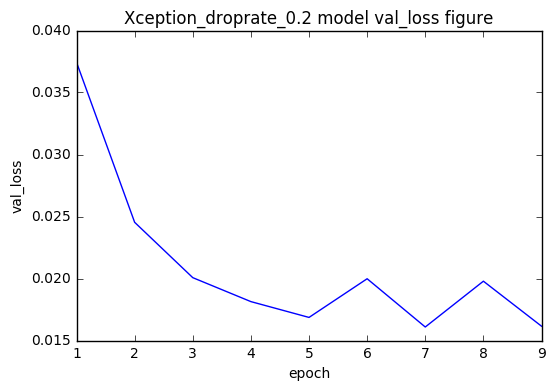

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline
with open('log_Xception_droprate_0.2.txt', 'r') as f:
    log_str = f.read()
log_str = eval(log_str)
log_val_loss = log_str['val_loss']
log_epoch = np.linspace(1,len(log_val_loss),len(log_val_loss))
plt.plot(log_epoch, log_val_loss)
plt.title('Xception_droprate_0.2 model val_loss figure')  
plt.xlabel('epoch')  
plt.ylabel('val_loss') 
plt.show()

In [18]:
from keras.models import model_from_json
with open('Xception_droprate_0.2.json', 'r') as f:
    jason_str = f.read()
model = model_from_json(jason_str)
model.load_weights('Xception_droprate_0.2.h5')

In [19]:
Img_enerator = ImageDataGenerator(rescale=1./255)
test_generator = Img_enerator.flow_from_directory(
        'test',
        target_size=(299, 299),
        batch_size=BatchSize,
        class_mode='binary',
        shuffle = False)
test = model.predict_generator(test_generator,len(test_generator.filenames)/BatchSize )

Found 12500 images belonging to 1 classes.


In [20]:
y_pred = test.clip(min=0.005, max=0.995)

import pandas as pd
from keras.preprocessing.image import *

df = pd.read_csv("sample_submission.csv")

# 获取文件的序号并减1，然后设置到新预测的csv文件的序号
for i, fname in enumerate(test_generator.filenames):
    index = int((fname.split('\\')[1]).split('.')[0])
    df.set_value(index-1, 'label', y_pred[i])

df.to_csv('Xception_droprate_0.2_sub.csv', index=None)
df.head(10)

,id,label
0,1,0.995
1,2,0.995
2,3,0.995
3,4,0.995
4,5,0.005
5,6,0.005
6,7,0.005
7,8,0.005
8,9,0.005
9,10,0.005
